In [2]:
# data
import pandas as pd
import numpy as np
from datetime import datetime
from math import ceil

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# processing
from sklearn.impute import KNNImputer
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.base import clone

# clustering models
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# metrics
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples

# multidimensional visualization methods
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
sns.set()
%matplotlib inline

### Data Exploration
- view the original dataset
- outliers
- null values

In [3]:
# read the dataset
df_full = pd.read_csv('H2.csv')

In [4]:
#traintest split here
X = df_full.drop('IsCanceled', axis = 1)
y = df_full['IsCanceled']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0, stratify = y, shuffle = True)

In [5]:
df=pd.concat([X_train,y_train], axis=1)

In [6]:
# create a copy of the original df for preprocessing
df_backup = df.copy()

In [7]:
# first rows - view the structure
df.head(25)

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsCanceled
12550,32,2016,June,24,8,0,4,2,2.0,0,...,9,NULL,0,Transient,191.70,0,0,Canceled,2016-05-30,1
11947,63,2016,May,22,28,2,1,2,0.0,0,...,9,NULL,0,Transient,140.40,0,0,No-Show,2016-05-28,1
72945,204,2017,May,22,28,2,2,2,0.0,0,...,9,NULL,0,Transient,133.65,0,1,Check-Out,2017-06-01,0
57016,12,2016,September,38,11,1,0,1,0.0,0,...,295,NULL,0,Transient-Party,85.00,0,1,Check-Out,2016-09-12,0
17539,447,2016,September,40,29,0,1,1,0.0,0,...,1,NULL,0,Transient,59.00,0,0,Canceled,2015-10-21,1
27709,99,2017,May,18,6,2,6,2,0.0,0,...,9,NULL,0,Transient,139.50,0,0,Canceled,2017-02-04,1
6938,30,2016,February,6,2,1,5,2,2.0,0,...,9,NULL,0,Transient,139.05,0,0,Canceled,2016-01-03,1
3822,87,2015,September,39,25,2,3,2,0.0,0,...,1,NULL,0,Transient,170.00,0,0,Canceled,2015-09-09,1
67399,57,2017,March,10,8,1,4,2,0.0,0,...,9,NULL,0,Transient,74.80,0,0,Check-Out,2017-03-13,0
6094,17,2015,December,51,18,0,2,2,0.0,0,...,9,NULL,0,Transient,87.00,0,1,Canceled,2015-12-14,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55531 entries, 12550 to 43777
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LeadTime                     55531 non-null  int64  
 1   ArrivalDateYear              55531 non-null  int64  
 2   ArrivalDateMonth             55531 non-null  object 
 3   ArrivalDateWeekNumber        55531 non-null  int64  
 4   ArrivalDateDayOfMonth        55531 non-null  int64  
 5   StaysInWeekendNights         55531 non-null  int64  
 6   StaysInWeekNights            55531 non-null  int64  
 7   Adults                       55531 non-null  int64  
 8   Children                     55529 non-null  float64
 9   Babies                       55531 non-null  int64  
 10  Meal                         55531 non-null  object 
 11  Country                      55514 non-null  object 
 12  MarketSegment                55531 non-null  object 
 13  Distribution

In [9]:
'''
weeks of the year has one value of 53
babies has an outlier of 9 and 10
days in waiting list has outliers
NULL text string is inplace of nans often
we need to do some transformations on the date variables
do we need the company or can we make it a binary variable
consider changing Babies to binary variable
lots of categorical variables to check 
possible created feature: percentage of weekend nights in the stay
consider logADR depending on the distribution
4 nans in Children - fill with 0
we have a few duplicated values
'''

'\nweeks of the year has one value of 53\nbabies has an outlier of 9 and 10\ndays in waiting list has outliers\nNULL text string is inplace of nans often\nwe need to do some transformations on the date variables\ndo we need the company or can we make it a binary variable\nconsider changing Babies to binary variable\nlots of categorical variables to check \npossible created feature: percentage of weekend nights in the stay\nconsider logADR depending on the distribution\n4 nans in Children - fill with 0\nwe have a few duplicated values\n'

In [10]:
# the dataset has null values
df[df.Children.isna()]

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsCanceled
607,1,2015,August,32,5,0,2,2,NaN,0,...,14,NULL,0,Transient-Party,12.0,0,1,Canceled,2015-08-04,1
619,1,2015,August,32,5,0,2,3,NaN,0,...,NULL,NULL,0,Transient-Party,18.0,0,2,Canceled,2015-08-04,1


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LeadTime,55531.0,109.579874,110.742749,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,55531.0,2016.175776,0.699583,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateWeekNumber,55531.0,27.151429,13.398175,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,55531.0,15.767553,8.717110,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,55531.0,0.796672,0.886532,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,55531.0,2.183393,1.463527,0.0,1.0,2.0,3.0,41.0
Adults,55531.0,1.852605,0.507934,0.0,2.0,2.0,2.0,4.0
Children,55529.0,0.090511,0.371392,0.0,0.0,0.0,0.0,3.0
Babies,55531.0,0.004880,0.081592,0.0,0.0,0.0,0.0,10.0
IsRepeatedGuest,55531.0,0.025139,0.156549,0.0,0.0,0.0,0.0,1.0


In [12]:
df.MarketSegment.unique()

array(['Online TA', 'Offline TA/TO', 'Groups', 'Direct', 'Corporate',
       'Complementary', 'Aviation', 'Undefined'], dtype=object)

In [13]:
df.select_dtypes(exclude=np.number).columns

Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
       'DepositType', 'Agent', 'Company', 'CustomerType', 'ReservationStatus',
       'ReservationStatusDate'],
      dtype='object')

In [14]:
df.duplicated().value_counts()

False    38825
True     16706
dtype: int64

In [15]:
#there were duplicated observations. 
df[(df.duplicated()==True)&(df.LeadTime==27)]

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsCanceled
4068,27,2015,September,40,30,0,2,2,0.0,0,...,64,NULL,21,Transient,108.00,0,0,Canceled,2015-09-24,1
4073,27,2015,September,40,30,0,2,2,0.0,0,...,64,NULL,21,Transient,108.00,0,0,Canceled,2015-09-24,1
10813,27,2016,May,20,10,0,3,2,0.0,0,...,9,NULL,0,Transient,141.00,0,0,Canceled,2016-04-13,1
12580,27,2016,June,24,9,0,1,2,0.0,0,...,191,NULL,0,Transient-Party,120.00,0,0,Canceled,2016-06-02,1
446,27,2015,July,31,27,1,1,2,0.0,0,...,1,NULL,0,Transient-Party,62.00,0,0,Canceled,2015-07-02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13577,27,2016,June,27,26,2,1,2,0.0,0,...,9,NULL,0,Transient,152.67,0,0,Canceled,2016-05-31,1
461,27,2015,July,31,27,1,1,2,0.0,0,...,1,NULL,0,Transient-Party,62.00,0,0,Canceled,2015-07-02,1
57804,27,2016,September,39,20,0,1,2,0.0,0,...,288,NULL,0,Transient-Party,95.00,0,0,Check-Out,2016-09-21,0
4051,27,2015,September,40,30,0,2,2,0.0,0,...,64,NULL,21,Transient,108.00,0,0,Canceled,2015-09-24,1



### Remove Outliers

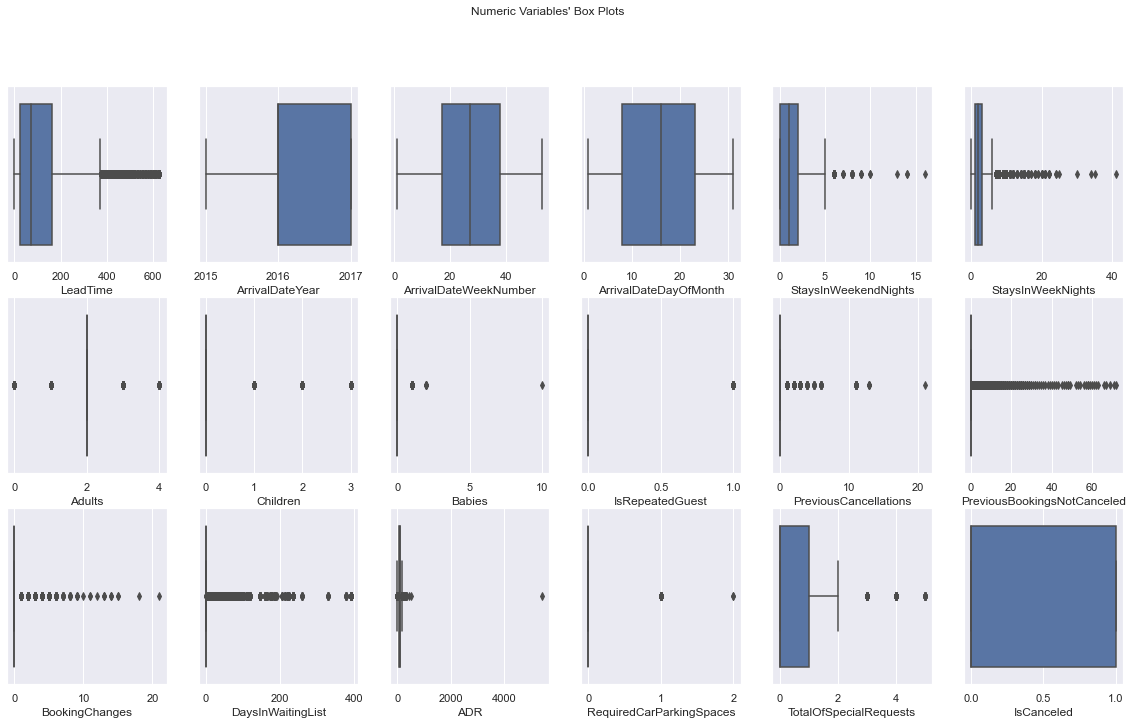

In [16]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.boxplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [ ]:
'''manual outlier removal:
Babies
ADR
DaysInWaitingList'''

In [17]:
filters1 = (
    (df['Babies']<=5)
    &
    (df['ADR']<=2000)
    &
    (df['DaysInWaitingList']<=300)
)

df = df[filters1]

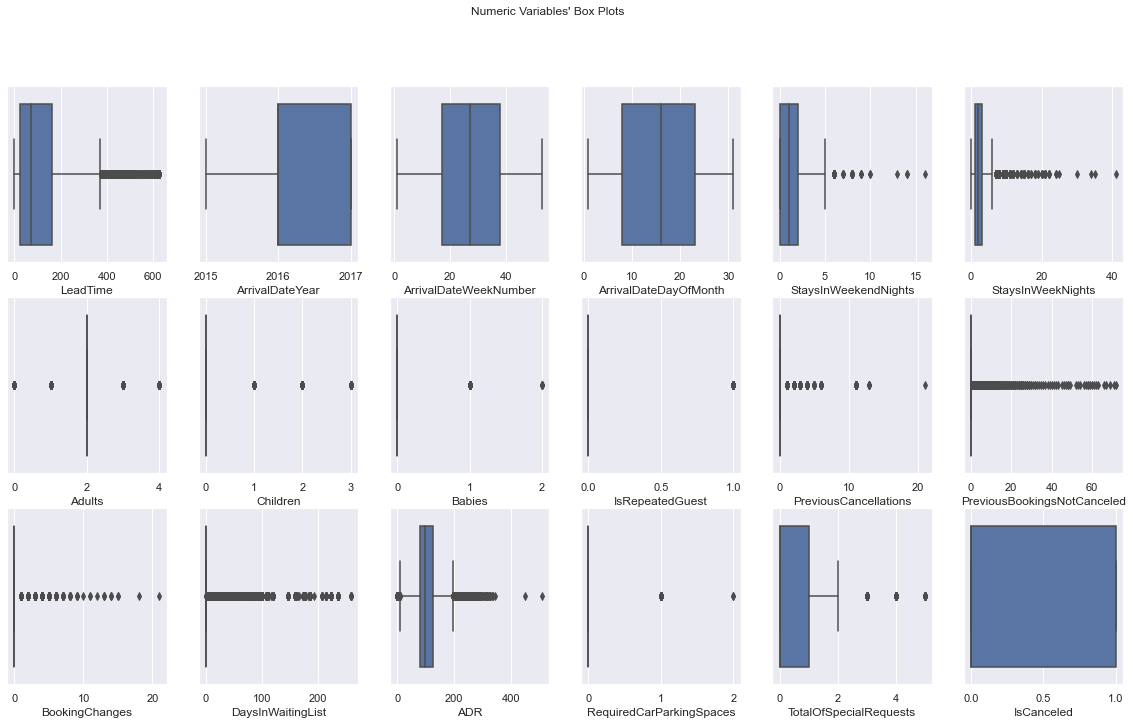

In [19]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.boxplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

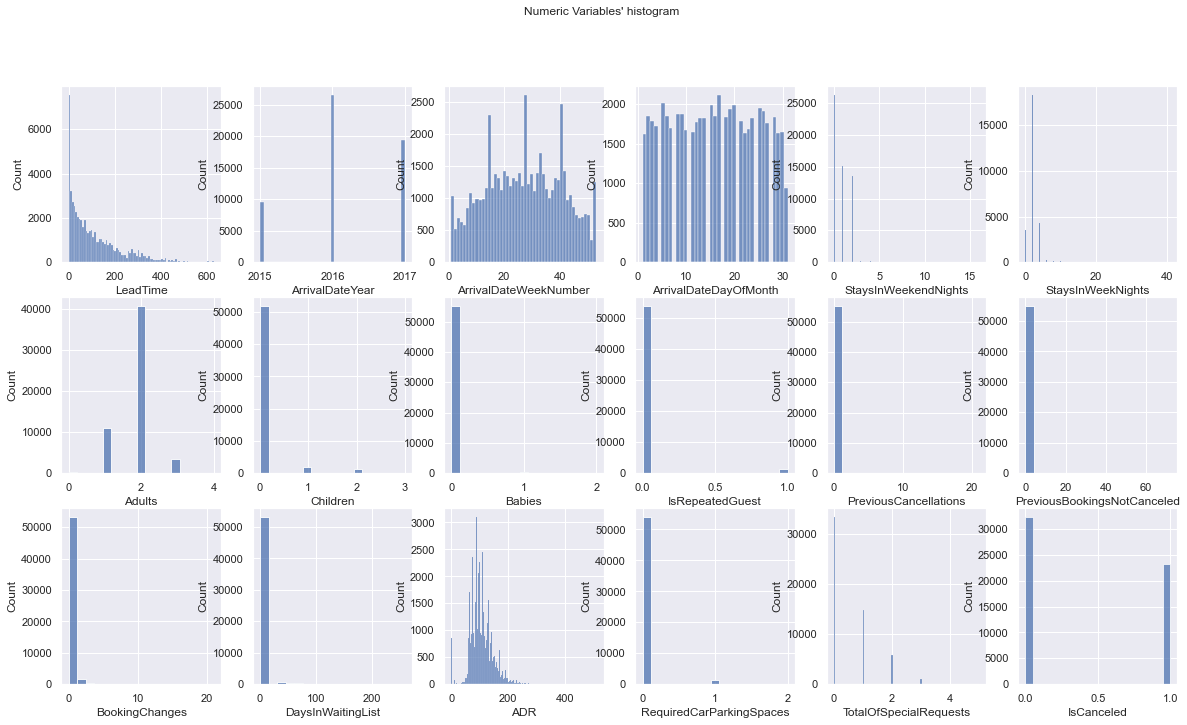

In [20]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.histplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' histogram"

plt.suptitle(title)

plt.show()

## Fill Missing Values

In [21]:
#check for =="NULL" as well as .isna()
df.Children.fillna(0, inplace = True)

In [47]:
df.replace('       NULL',np.nan, inplace=True)
df.replace('NULL',np.nan, inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55471 entries, 12550 to 43777
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LeadTime                     55471 non-null  int64  
 1   ArrivalDateYear              55471 non-null  int64  
 2   ArrivalDateMonth             55471 non-null  object 
 3   ArrivalDateWeekNumber        55471 non-null  int64  
 4   ArrivalDateDayOfMonth        55471 non-null  int64  
 5   StaysInWeekendNights         55471 non-null  int64  
 6   StaysInWeekNights            55471 non-null  int64  
 7   Adults                       55471 non-null  int64  
 8   Children                     55471 non-null  float64
 9   Babies                       55471 non-null  int64  
 10  Meal                         55471 non-null  object 
 11  Country                      55454 non-null  object 
 12  MarketSegment                55471 non-null  object 
 13  Distribution

### Feature Engineering:

In [49]:
df.columns

Index(['LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'IsCanceled'],
      dtype='object')

In [56]:
#Created columns:
df["StayLength"]=df.StaysInWeekendNights+df.StaysInWeekNights
df["Revenue"]=df.StayLength*df.ADR
df["logADR"]=df["ADR"].map(lambda x : 1 if x<=1 else x)
df["logADR"]=np.log(df["logADR"])
df["logRevenue"]=df["Revenue"].map(lambda x : 1 if x<=1 else x)
df["logRevenue"]=np.log(df["logRevenue"])

In [57]:
df[df.ADR==0]

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsCanceled,StayLength,Revenue,logADR,logRevenue
42935,4,2016,January,2,9,1,1,2,0.0,0,...,0.0,1,1,Check-Out,2016-01-11,0,2,0.0,0.0,0.0
54338,1,2017,August,32,8,0,1,1,0.0,0,...,0.0,0,3,Check-Out,2017-08-09,0,1,0.0,0.0,0.0
67097,0,2017,March,10,9,0,0,0,0.0,0,...,0.0,0,0,Check-Out,2017-03-09,0,0,0.0,0.0,0.0
56846,0,2016,September,37,9,0,1,2,0.0,0,...,0.0,0,1,Check-Out,2016-09-10,0,1,0.0,0.0,0.0
1825,1,2015,August,35,26,0,1,1,0.0,0,...,0.0,0,2,Check-Out,2015-08-27,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47452,33,2016,April,17,18,1,2,2,0.0,0,...,0.0,0,1,Check-Out,2016-04-21,0,3,0.0,0.0,0.0
49045,0,2016,May,21,17,0,0,2,0.0,0,...,0.0,0,0,Check-Out,2016-05-17,0,0,0.0,0.0,0.0
47039,14,2016,April,16,13,0,1,1,0.0,0,...,0.0,0,1,Check-Out,2016-04-14,0,1,0.0,0.0,0.0
54325,1,2017,May,18,4,0,2,2,0.0,0,...,0.0,0,2,Canceled,2017-05-04,1,2,0.0,0.0,0.0


## Feature selection: Chi squared test? ANOVA?

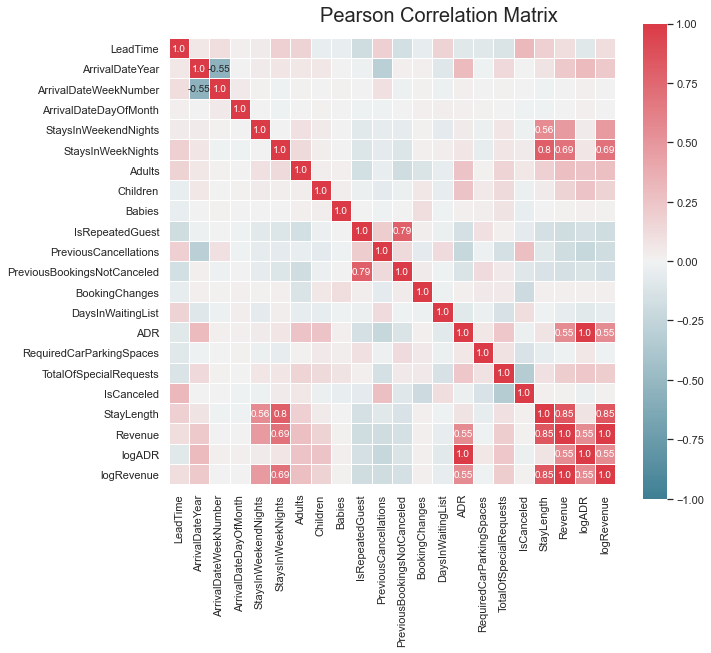

In [58]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df.corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

In [ ]:
'''So using feature selection techniques we can conclude: 


'''

In [ ]:
'''other considerations for ML algorithm
fairly balanced (41%)
should scale the data'''

In [107]:
df.to_csv('cleaned_data.csv')